In [2]:
import warnings
warnings.filterwarnings("ignore")

import io
import os
import os.path
import re
import spacy
import time
import pickle

import pandas as pd
from pprint import pprint

import gensim
from gensim.models import Phrases, LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
os.environ.update({'MALLET_HOME':r'C:/mallet/mallet-2.0.8/'})
mallet_path = 'C:\\mallet\\mallet-2.0.8\\bin\\mallet'
pd.options.display.max_columns = 100

C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\f.braulio\Anaconda3\envs\ugpn-covid-emotions\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [2]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
#         model = LdaModel(
#             corpus=corpus,
#             id2word=id2word,
#             chunksize=chunksize,
#             alpha='auto',
#             eta='auto',
#             iterations=iterations,
#             num_topics=num_topics,
#             passes=passes,
#             eval_every=eval_every
#         )
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())

    return model_list, coherence_values

In [3]:
tweets = pd.read_parquet('./../data/raw/news_tweets.parquet').sample(frac=1, random_state=3)
tweets = tweets.reset_index(drop=True)
data = list(tweets.content)
print("Just collected", len(data), "tweets.")

# Clean data
start = time.time()
nlp = spacy.load("en_core_web_sm")
docs = []
for doc in nlp.pipe(data, disable=["tok2vec", "tagger", "parser", "attribute_ruler"]):
    docs.append([
        re.sub(r'[^\w\s]|[0-9]|[_]', '', token.lemma_.lower()) for token in doc
        if not token.like_url
        and not token.is_punct
        and not token.is_stop
        and not token.is_space
        and not token.like_num
        and not token.ent_type_ == 'GPE'
        and not token.text.startswith('@')
        and len(token.text)>1
    ])
print("Finish 1", time.time() - start)

# Form Bigrams and Trigrams
start = time.time()
bigram = gensim.models.Phrases(docs, min_count=5, ) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[docs])
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
docs = make_bigrams(docs)
docs = make_trigrams(docs)
print("Finish 2", time.time() - start)

# Create a dictionary representation of the documents.
start = time.time()
dictionary = Dictionary(docs)
print("Finish 3", time.time() - start)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
start = time.time()
dictionary.filter_extremes(no_below=len(docs)*0.0005, no_above=0.33)
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token
print("Finish 4", time.time() - start)

# Bag-of-words representation of the documents.
start = time.time()
corpus = [dictionary.doc2bow(doc) for doc in docs]
print("Finish 5", time.time() - start)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Just collected 1814506 tweets.
Finish 1 2304.1617822647095
Finish 2 489.37044882774353
Finish 3 37.27526807785034
Finish 4 0.380770206451416
Finish 5 16.250972747802734
Number of unique tokens: 1975
Number of documents: 1814506


In [ ]:
# import pickle
# with open("docs.txt", "wb") as fp:   #Pickling
#     pickle.dump(docs, fp) 
# with open("test.txt", "rb") as fp:   # Unpickling
#     b = pickle.load(fp)

In [13]:
with open("data_pp.pickle", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [31]:
tweets = pd.read_parquet('./../data/raw/news_tweets.parquet').sample(frac=1, random_state=3)
tweets = tweets.reset_index(drop=True)
data = list(tweets.content)

In [34]:
tweets.iloc[0,:]

tweetId                                         1331811812828803073
conversationId                                  1331811812828803073
userId                                                     55118669
date                                      2020-11-26 04:07:34+00:00
content           Less than a year after an unknown coronavirus ...
lang                                                             en
sourceLabel                                               TweetDeck
replyCount                                                        0
retweetCount                                                      2
likeCount                                                         8
quoteCount                                                        0
longitude                                                       NaN
latitude                                                        NaN
place                                                          None
Name: 0, dtype: object

In [53]:
data[0]

'Less than a year after an unknown coronavirus that has claimed 1.4 million lives began spreading across the globe, a number of highly promising COVID-19 vaccines are on the cusp of release \n\nhttps://t.co/fx7gdVNYbO'

In [4]:
def compute_coherence_values(id2word, corpus, texts, limit, mallet_path, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, random_seed=50)
        model_list.append(ldamallet)
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_ldamallet.get_coherence())
        print(num_topics)
    return model_list, coherence_values

In [15]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word, random_seed=50, workers=7, alpha=25)
CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v').get_coherence()

0.28604413114162136

In [13]:
coherence_model_ldamallet.get_coherence()

0.4582848885346675

In [6]:
coherence_values

[0.20358866182495022,
 0.35812993607968135,
 0.4137227508276471,
 0.45879723439594605,
 0.4903186970103492,
 0.49442360909967475,
 0.5092837897212853,
 0.5104064790527232,
 0.5184022248959052,
 0.5228645652295535,
 0.541855925166316,
 0.5391412493066043,
 0.5432144632110592]

In [ ]:
# Can take a long time to run.
limit=40; start=2; step=3;
model_list, coherence_values = compute_coherence_values(id2word=id2word, corpus=corpus, texts=docs, mallet_path=mallet_path, start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
topics = [
    ['case', 'state', 'rise', 'death', 'report', 'infection', 'confirm', 'maharashtra', 'numb', 'increase', 'total', 'coronavirusoutbreak', 'high', 'recovery', 'govt', 'surge', 'record', 'coronaviruspandemic', 'daily', 'breaking', 'positive', 'number', 'active_case', 'district', 'hour', 'spike', 'continue', 'death_toll', 'health_ministry', 'rate', 'fatality', 'live_update', 'low', 'additional', 'lakh', 'jump', 'total_numb', 'today', 'reach', 'discharge', 'fresh', 'mark', 'department_health', 'county', 'tally', 'include', 'bring_total', 'register', 'double', 'past_hour', 'newsalert', 'drop', 'climb', 'live_updates', 'soar', 'karnataka', 'recover', 'covidindia', 'record_high', 'relate_death', 'covidー', 'count', 'log', 'yesterday', 'fall', 'patient_recover', 'follow_live_update', 'worldwide', 'death_toll_rise', 'centre', 'hospitalization', 'doh', 'tamil_nadu', 'bring_total_numb', 'coronavirusupdates', 'peak', 'union_health_ministry', 'health_department', 'hit', 'additional_death', 'pune', 'trend', 'stand', 'telangana', 'country', 'punjab', 'toll', 'cases', 'infection_rate', 'bring', 'bihar', 'single_day', 'total_active', 'previous', 'high_daily', 'indiafightscorona', 'positivity_rate', 'filipino_abroad', 'rajasthan', 'top', 'victoria_record_new', 'coronavirusindia', 'exceed', 'ministry_health', 'mumbai', 'past_week', 'dfa', 'kerala', 'dip', 'cross', 'decrease', 'updates', 'reports', 'past_day', 'assam', 'consecutive_day', 'madhya_pradesh', 'milestone', 'recovery_rate', 'western_cape', 'pradesh', 'rapidly', 'follow_live_updates', 'overtake', 'coronavirusupdate', 'day', 'odisha', 'take_total_numb', 'west_bengal', 'high_single_day', 'seal', 'kashmir', 'kaduna', 'tally_rise', 'wrong_hit', 'uttarakhand', 'uttarpradesh', 'gujarat', 'tamilnadu'],
    ['pandemic', 'year', 'worker', 'amid', 'vaccination', 'plan', 'impact', 'work', 'crisis', 'business', 'government', 'hold', 'economy', 'community', 'deal', 'hit', 'group', 'fund', 'global', 'support', 'cancel', 'demand', 'offer', 'house', 'market', 'free', 'sign', 'company', 'launch', 'event', 'job', 'employee', 'relief', 'industry', 'provide', 'seek', 'half', 'service', 'ongoing', 'cost', 'food', 'postpone', 'cut', 'ensure', 'aid', 'expect', 'centre', 'push', 'cent', 'pay', 'budget', 'big', 'effort', 'pass', 'sector', 'affect', 'delay', 'boost', 'urge', 'money', 'sale', 'citizen', 'congress', 'price', 'target', 'concern', 'bank', 'include', 'bill', 'stock', 'cover', 'power', 'quarter', 'nstnation', 'spend', 'firm', 'poor', 'massive', 'sell', 'protect', 'season', 'trade', 'people', 'reuters', 'drive', 'host', 'percent', 'benefit', 'law', 'loss', 'vulnerable', 'light', 'fall', 'access', 'celebrate', 'growth', 'donate', 'set', 'financial', 'site', 'lawmaker', 'estimate', 'involve', 'propose', 'household', 'fight', 'party', 'struggle', 'office', 'senate', 'product', 'essential', 'package', 'loan', 'app', 'parliament', 'shock', 'initiative', 'unveil', 'bernama', 'relief_bill', 'revenue', 'social', 'small_business', 'gain', 'malaysian', 'supreme_court', 'economic_recovery', 'apply', 'annual', 'lose_job', 'location', 'farmer', 'debt', 'public', 'celebration', 'profit', 'sabah', 'relief_package', 'fallout', 'programme', 'festival', 'weigh', 'workplace', 'call', 'performance', 'scheme', 'session', 'oil', 'healthcare', 'proposal', 'month', 'donation', 'file', 'global_economy', 'plant', 'stimulus_package', 'economist', 'employer', 'judge', 'credit', 'assistance', 'inquiry', 'boom', 'mission', 'legal', 'job_loss', 'network', 'stall', 'world_bank', 'amazon', 'violence', 'pain', 'commit', 'owe', 'tool', 'registration', 'relief_fund', 'google', 'mco', 'vital', 'organisation'],
    ['school', 'home', 'close', 'amid', 'open', 'student', 'child', 'return', 'pandemic', 'force', 'leave', 'reopen', 'shut', 'online', 'send', 'stay', 'learn', 'safe', 'parent', 'kid', 'restaurant', 'scare', 'shutdown', 'university', 'miss', 'store', 'teacher', 'closure', 'education', 'summer', 'work_home', 'class', 'turn', 'bring', 'finally', 'virtual', 'option', 'migrant', 'work', 'space', 'owner', 'college', 'fee', 'teach', 'children', 'exam', 'reopen_school', 'safely', 'gym', 'eat', 'teen', 'pet', 'shelter', 'girl', 'meal', 'mom', 'parents', 'remain_open'],
    ['time', 'test_positive', 'world', 'news', 'pandemic', 'die', 'face', 'people', 'post', 'man', 'change', 'family', 'write', 'woman', 'life', 'contract', 'challenge', 'resident', 'share', 'year_old', 'make', 'person', 'opinion', 'breaking', 'experience', 'australian', 'thing', 'reveal', 'big', 'age', 'good', 'victoria', 'happen', 'nsw', 'wrong', 'victim', 'future', 'couple', 'long', 'kill', 'feel', 'infect', 'problem', 'diagnose', 'great', 'nurse_home', 'survive', 'wife', 'lot', 'visit', 'hope', 'isolation', 'play', 'hotel_quarantine', 'create', 'mother', 'cope', 'young', 'mental_health', 'jail', 'stress', 'prison', 'love', 'victorian', 'real', 'son', 'history', 'care_home', 'social_medium', 'cop', 'normal', 'test_negative', 'moment', 'complication', 'difficult', 'dozen', 'story', 'catch', 'film', 'daughter', 'bring', 'reportedly', 'opportunity', 'husband', 'reality', 'inmate', 'look_like', 'father', 'era', 'year_old_man', 'new_normal', 'mum', 'kind', 'baby', 'digital', 'leave', 'devastate', 'year_old_woman', 'decade', 'quarantine_hotel', 'music', 'home', 'bite', 'funeral', 'art', 'dad', 'overcome', 'pass_away', 'environment', 'sydney', 'perspective', 'relative', 'song'],
    ['response', 'update', 'live', 'trump', 'late', 'amp', 'american', 'official', 'watch', 'call', 'early', 'pm', 'emergency', 'give', 'meet', 'president', 'province', 'today', 'nation', 'release', 'situation', 'national', 'datum', 'video', 'lead', 'health_official', 'speak', 'team', 'accord', 'talk', 'claim', 'canadian', 'join', 'president_trump', 'month', 'question', 'crisis', 'watch_live', 'minister', 'declare', 'january', 'discuss', 'handle', 'news', 'fight', 'white_house', 'tuesday', 'health_minister', 'leader', 'expect', 'detail', 'expert', 'relate', 'listen', 'address', 'december', 'pm_modi', 'election', 'thursday', 'indian', 'analysis', 'senior', 'special', 'governor', 'september', 'govt', 'policy', 'week', 'explain', 'president_donald_trump', 'ottnews', 'review', 'task_force', 'february', 'tomorrow', 'action', 'track', 'tonight', 'approach', 'friday', 'union', 'donald_trump', 'public_health', 'india', 'administration', 'follow', 'answer', 'fail', 'federal', 'exclusive', 'respond', 'october', 'story', 'biden', 'source', 'mp', 'poll', 'vaccine_rollout', 'catch', 'pandemic', 'november', 'follow_update', 'accuse', 'wednesday', 'bjp', 'attack', 'africa', 'vmnews', 'slam', 'begin', 'interview', 'head', 'outbreak', 'tv', 'model', 'states', 'win', 'quebec', 'political', 'sabcnews', 'times', 'diagnosis', 'provide_update', 'grind', 'joe_biden', 'guidance', 'conversation', 'defend', 'publish', 'newsnight', 'debate', 'thread', 'discussion', 'comment', 'trudeau', 'tune', 'trump_administration', 'weekly', 'chair', 'twitter', 'commission', 'answer_question', 'trust', 'ontario', 'preparedness', 'dr_anthony_fauci', 'tracker', 'pm_narendra_modi', 'failure', 'provincial', 'warrior', 'leadership', 'chief_medical_officer', 'episode', 'defeat', 'covidab', 'dstv', 'praise', 'cdnpoli', 'coming', 'criticism', 'statistic', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'headline', 'voter', 'projection', 'speech', 'historic', 'government', 'climate_change'],
    ['day', 'order', 'lockdown', 'country', 'travel', 'restriction', 'read', 'start', 'quarantine', 'measure', 'disease', 'week', 'police', 'ease', 'city', 'issue', 'level', 'area', 'march', 'social_distance', 'place', 'sa', 'announce', 'follow', 'rule', 'list', 'april', 'guideline', 'impose', 'add', 'end', 'protocol', 'lift', 'ph', 'extend', 'mask', 'boris_johnson', 'filipino', 'begin', 'public', 'weekend', 'na', 'monday', 'suspend', 'curb', 'government', 'month', 'passenger', 'protest', 'ang', 'june', 'flight', 'strict', 'doh', 'july', 'wear_mask', 'christmas', 'ng', 'sunday', 'resume', 'anti', 'remain', 'nationwide', 'train', 'break', 'ncov', 'decide', 'check', 'curfew', 'roque', 'period', 'hotel', 'metro_manila', 'complete', 'relax', 'icymi', 'saturday', 'holiday', 'ahead', 'national', 'august', 'arrest', 'stage', 'duterte', 'set', 'require', 'tough', 'arrive', 'friday', 'urge', 'enforce', 'president_rodrigo_duterte', 'date', 'breach', 'street', 'monitor', 'extension', 'airport', 'limit', 'arrival', 'bengaluru', 'fine', 'plan', 'region', 'need_know', 'player', 'brit', 'quarantine_facility', 'tuesday', 'advice', 'crowd', 'enhance_community_quarantine', 'village', 'ban', 'johnson', 'affect', 'relaxation', 'airline', 'personnel', 'average', 'activity', 'decision', 'president_duterte', 'covidpandemic', 'violate', 'local_government', 'phase', 'authority', 'pub', 'abroad', 'goa', 'game', 'part', 'malacañang', 'photos', 'tourism', 'include', 'induce', 'mandatory', 'exercise', 'wednesday', 'chandigarh', 'fly', 'local', 'frontliners', 'ottnews_ottawa', 'church', 'tier', 'community_quarantine', 'haryana', 'fan', 'stay_home_order', 'duque', 'containment_zone', 'easter', 'covidquarantine', 'traveller', 'restriction_ease', 'travel_ban', 'chennai', 'prevent_spread', 'mall', 'galvez', 'quarantine_period', 'norm', 'tighten', 'philippine', 'mid', 'precaution', 'ease_restriction', 'recommendation', 'trip', 'slow_spread', 'wa', 'land', 'protester', 'cdntopstories', 'observe', 'confusion', 'pnp', 'club', 'briton', 'lgus', 'flout', 'alert_level', 'curve', 'driver', 'social_distance_measure', 'distance', 'exit', 'ofws', 'spot', 'enforcement', 'yung', 'guest', 'ncr', 'football', 'prime_minister_boris_johnson', 'presidential_spokesperson_harry_roque', 'station', 'mkhize', 'muslim', 'health_secretary_francisco', 'vaccine_passport', 'reiterate', 'match', 'compliance', 'comply'],
    ['patient', 'test', 'outbreak', 'hospital', 'people', 'spread', 'health', 'find', 'warn', 'doctor', 'study', 'virus', 'battle', 'variant', 'fear', 'treatment', 'result', 'wave', 'facility', 'symptom', 'vanguardnews', 'treat', 'risk', 'care', 'infect', 'chinese', 'medical', 'positive', 'europe', 'system', 'show', 'control', 'nurse', 'strain', 'malay_mail', 'staff', 'conduct', 'deadly', 'chief', 'detect', 'stop', 'fight', 'identify', 'nigerian', 'inside', 'research', 'grow', 'line', 'screen', 'cluster', 'build', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'admit', 'carry', 'prevent', 'body', 'expose', 'concern', 'healthcare_worker', 'negative', 'worry', 'run', 'transmission', 'fg', 'condition', 'contact', 'fmtnews', 'lagos', 'evidence', 'world_health_organization', 'bed', 'wait', 'epidemic', 'shift', 'reduce', 'link', 'health_worker', 'population', 'thecable', 'suspect', 'country', 'work', 'human', 'emerge', 'fire', 'test_result', 'lock', 'officer', 'undergo', 'nstworld', 'recover', 'test_kit', 'global', 'critical', 'suggest', 'nigeria', 'ventilator', 'sample', 'panic', 'nhs', 'asymptomatic', 'ncdc', 'doctors', 'develop', 'quickly', 'sick', 'antibody', 'wrong', 'health_care_worker', 'icmr', 'buhari', 'icu', 'study_find', 'medicine', 'rapid', 'winter', 'ward', 'scientists', 'spark', 'describe', 'high_risk', 'lead', 'frontline', 'exposure', 'resurgence', 'private_hospital', 'trace', 'expert_warn', 'duty', 'close_contact', 'epicentre', 'commissioner', 'animal', 'new_youtube', 'army', 'long', 'origin', 'overwhelm', 'caution', 'oxygen', 'claim', 'china', 'save_live', 'mutation', 'danger', 'ppe', 'researchers', 'epicenter', 'intensive_care', 'study_show', 'ptf', 'hospitals', 'ability', 'palliative', 'aiims', 'infectious', 'gravitas', 'dedicate', 'rapid_test', 'scam', 'equipment', 'asian', 'transfer', 'fears'],
    ['vaccine', 'dose', 'receive', 'astrazeneca', 'trial', 'supply', 'ready', 'jab', 'shoot', 'approve', 'pfizer', 'roll', 'develope', 'effective', 'eu', 'development', 'vaccinate', 'shot', 'deliver', 'distribution', 'race', 'delivery', 'covidvaccine', 'administer', 'volunteer', 'produce', 'distribute', 'approval', 'johnson_amp_johnson', 'clinical_trial', 'rollout', 'vaccination', 'fda', 'moderna', 'manufacture', 'russian', 'potential', 'sinovac', 'pfizer_biontech', 'vaccine_candidate', 'give', 'manufacturer', 'experimental', 'shipment', 'covishield', 'procure']
]

In [43]:
ch2 = CoherenceModel(topics=topics, texts=docs, dictionary=dictionary, coherence='c_v')
cm2 = ch2.get_coherence()
ct2 = ch2.get_coherence_per_topic()

In [30]:
ch = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
cm = ch.get_coherence()
ct = ch.get_coherence_per_topic()

In [37]:
ct

[0.5045240018586463,
 0.457429369616528,
 0.39920349346028877,
 0.632010435653083,
 0.5676439882354302,
 0.7761133997948086,
 0.4258232788488341,
 0.40830264158623547,
 0.45647835420339933,
 0.5317752172531746,
 0.5020692943267668,
 0.5413021154766547,
 0.5135971149032914,
 0.3908425767860518,
 0.49576224182692885,
 0.6483536339736877,
 0.5485482238894555,
 0.4492176147115874,
 0.5023008732303528,
 0.4343779247905027]

In [45]:
cm2

0.4176788044591231

In [44]:
ct2

[0.5459828234103381,
 0.3692984340037231,
 0.4957032362906711,
 0.3049389606300409,
 0.3250778286215447,
 0.3490729300288671,
 0.3126503754655304,
 0.6387058472222693]

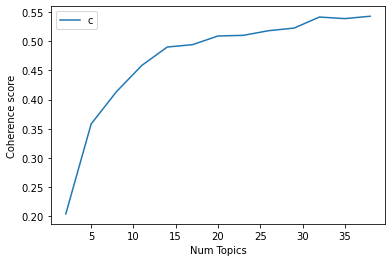

In [7]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
coherence_values

In [8]:
ldamallet = LdaModel.load(datapath("model"))

In [17]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
temp_file = datapath("model")
ldamallet.save(temp_file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5      0.376622 -0.126622       1        1  5.087497
3      0.336078 -0.096200       2        1  5.024331
4     -0.117955 -0.197921       3        1  5.020962
6     -0.058879  0.085983       4        1  5.014223
19    -0.003304  0.156945       5        1  5.012755
18    -0.151992 -0.238179       6        1  5.012173
9      0.009251  0.223078       7        1  5.012034
12     0.010238 -0.002856       8        1  5.008033
15    -0.030969  0.037682       9        1  5.004493
16     0.322865 -0.081289      10        1  4.997197
14    -0.129178 -0.115867      11        1  4.995125
10    -0.040888  0.124812      12        1  4.992945
7     -0.025928  0.193648      13        1  4.989978
2     -0.188223 -0.192700      14        1  4.987231
8     -0.019613  0.081538      15        1  4.986988
0     -0.027866  0.035205      16        1  4.983835
1     -0.151192 -0.170714      17        1  4.980991
11    -0.059982  0.191090      18        1  4.979268
13    -0.041649  0.022337      19        1  4.955859
17    -0.007435  0.070030      20        1  4.954081, topic_info=              Term           Freq          Total Category  logprob  loglift
8          vaccine  190645.000000  190645.000000  Default  30.0000  30.0000
69            case  278713.000000  278713.000000  Default  29.0000  29.0000
93        lockdown  202605.000000  202605.000000  Default  28.0000  28.0000
44        pandemic  249877.000000  249877.000000  Default  27.0000  27.0000
47          report  117181.000000  117181.000000  Default  26.0000  26.0000
..             ...            ...            ...      ...      ...      ...
514          visit    5273.091167   10803.610040  Topic20  -4.6086   2.2877
777  test_negative    3618.378447    6793.575955  Topic20  -4.9852   2.3750
104           home    4683.771554   31527.772248  Topic20  -4.7271   1.0982
170          leave    3926.231976   16556.998702  Topic20  -4.9035   1.5658
267          catch    3653.561707    8625.110479  Topic20  -4.9755   2.1460

[1167 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1322     15  1.000331    ability
991       5  0.999892     abroad
816       4  0.874900     access
816       9  0.125222     access
162      11  0.000455     accord
...     ...       ...        ...
658      10  0.880303  yesterday
1019     14  0.005021      young
1019     17  0.052282      young
1019     20  0.942840      young
852       5  1.000335       yung

[2059 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 7, 20, 19, 10, 13, 16, 17, 15, 11, 8, 3, 9, 1, 2, 12, 14, 18])

In [176]:
vis.sorted_terms(1, 0.64).Term.values

array(['case', 'death', 'confirm', 'report', 'total', 'recovery',
       'record', 'breaking', 'active_case', 'hour', 'death_toll',
       'fatality', 'additional', 'total_numb', 'discharge',
       'department_health', 'tally', 'bring_total', 'past_hour', 'climb',
       'reach', 'recover', 'relate_death', 'log', 'patient_recover',
       'death_toll_rise', 'doh', 'bring_total_numb',
       'union_health_ministry', 'additional_death', 'stand', 'today',
       'infection', 'bring', 'total_active', 'high_daily',
       'filipino_abroad', 'victoria_record_new', 'ministry_health', 'dfa'],
      dtype=object)

In [64]:
subthemes = [
    (1,11,['rise', 'increase', 'high', 'spike', 'jump', 'reach', 'double', 'climb', 'soar', 'record_high', 'death_toll_rise', 'peak', 'hit', 'high_daily', 'top', 'exceed', 'high_single_day', 'tally_rise']),
    (1,12,['low', 'drop', 'fall', 'dip', 'decrease']),
    (2,21,['worker', 'plan', 'work', 'support', 'free', 'job', 'employee', 'food', 'citizen', 'congress', 'poor', 'protect', 'people', 'vulnerable', 'household', 'essential', 'loan', 'small_business', 'lose_job', 'donation', 'employer', 'assistance', 'job_loss']),
    (2,22,['impact', 'business', 'government', 'economy', 'global', 'demand', 'market', 'company', 'industry', 'cut', 'aid', 'budget', 'sector', 'boost', 'bank', 'bill', 'stock', 'quarter', 'trade', 'law', 'growth', 'lawmaker', 'office', 'relief_bill', 'supreme_court', 'economic_recovery', 'debt', 'profit', 'relief_package', 'global_economy', 'stimulus_package', 'world_bank', 'relief_fund', 'organisation']),
    (4,41,['nurse_home', 'care_home']),
    (4,42,['mental_health']),
    (4,43,['jail', 'prison', 'cop', 'inmate']),
    (4,44,['family', 'couple', 'wife', 'mother', 'son', 'daughter', 'husband', 'father', 'mum', 'baby', 'dad']),
    (5,51,['health_official', 'health_minister', 'expert', 'task_force', 'public_health', 'dr_anthony_fauci', 'chief_medical_officer']),
    (5,52,['trump', 'pm', 'president', 'president_trump', 'minister', 'white_house', 'leader', 'pm_modi', 'governor', 'govt', 'president_donald_trump', 'donald_trump', 'administration', 'federal', 'biden', 'mp', 'joe_biden', 'trudeau', 'trump_administration', 'pm_narendra_modi', 'leadership', 'pres_trump', 'prime_minister_justin_trudeau', 'opposition', 'government']),
    (5,53,['election', 'poll', 'debate', 'voter']),
    (6,61,['lockdown', 'restriction', 'quarantine', 'police', 'rule', 'impose', 'protocol', 'quarantine_facility', 'mandatory', 'community_quarantine', 'stay_home_order', 'containment_zone', 'covidquarantine', 'quarantine_period']),
    (6,62,['travel', 'passenger', 'flight', 'airport', 'plan', 'airline', 'tourism', 'fly', 'traveller', 'travel_ban', 'trip', 'vaccine_passport']),
    (6,63,['protest', 'anti', 'break', 'arrest', 'fine', 'protester']),
    (6,64,['social_distance', 'mask', 'wear_mask', 'social_distance_measure']),
    (6,65,['christmas', 'holiday', 'easter']),
    (6,66,['ease', 'relax', 'restriction_ease', 'ease_restriction', 'slow_spread']),
    (7,71,['outbreak', 'fear', 'chinese', 'detect', 'epidemic', 'suspect', 'emerge', 'panic', 'epicentre', 'animal', 'origin', 'china', 'epicenter']),
    (7,72,['hospital', 'study', 'treatment', 'research', 'lab', 'expert', 'cure', 'researcher', 'scientist', 'ventilator', 'study_find', 'medicine', 'scientists', 'private_hospital', 'expert_warn', 'oxygen', 'researchers', 'intensive_care', 'study_show', 'hospitals', 'palliative']),
    (7,73,['variant', 'wave', 'strain', 'mutation']),
    (7,74,['doctor', 'medical', 'healthcare_worker', 'health_worker', 'doctors', 'health_care_worker'])
]

In [54]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])

In [56]:
df['topic'] = df.idxmax(axis=1)
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic
0,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.075000,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,topic_13
1,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.083333,0.046296,0.064815,0.046296,0.046296,0.046296,topic_14
2,0.044643,0.080357,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,topic_1
3,0.101562,0.070312,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.132812,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.039062,topic_8
4,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,topic_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814501,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_8
1814502,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.120370,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_11
1814503,0.044643,0.044643,0.080357,0.044643,0.062500,0.044643,0.062500,0.062500,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,topic_2
1814504,0.046296,0.046296,0.046296,0.046296,0.083333,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4


In [87]:
df_iter = ldamallet.load_document_topics()
df = []
for k in df_iter:
    df.append([i[1] for i in k])
df = pd.DataFrame(df, columns=[fr'topic_{k}' for k in range(20)])
df['topic'] = df.idxmax(axis=1)

In [62]:
topic2theme = pd.DataFrame({
    'topic':[fr'topic_{k}' for k in range(20)], 
    'theme':[7,3,2,1,2,1,2,5,7,6,6,6,5,7,5,8,1,4,4,6]
})

df = df.merge(topic2theme, how='left')

In [65]:
for col in [fr'subtheme{subtheme[1]}' for subtheme in subthemes]:
    df[col] = False

In [68]:
for k in range(1,9):
    subthemes_desc = [subtheme for subtheme in subthemes if subtheme[0]==k]
    if len(subthemes_desc)>0:
        indices = list(df[df.theme==k].index)
        topic_docs = [b[0][i] for i in indices]
        for subtheme_desc in subthemes_desc:
            kw = subtheme_desc[2]
            t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
            df.loc[t,fr'subtheme{subtheme_desc[1]}'] = True

In [70]:
tweets.tweetId.values

array([1331811812828803073, 1237432142214258688, 1234744569268338689, ...,
       1310723512223625216, 1266240991133970438, 1325600258848600065],
      dtype=int64)

In [71]:
df['tweetId'] = tweets.tweetId.values

In [73]:
df[[fr'topic_{k}' for k in range(20)]].max(axis=1).max()

0.2681159420289854

In [77]:
df.to_parquet('news_tweets_topics2.parquet', compression='gzip', index=False)

In [186]:
df.shape[0]

1814506

In [76]:
df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic,theme,subtheme11,subtheme12,subtheme21,subtheme22,subtheme41,subtheme42,subtheme43,subtheme44,subtheme51,subtheme52,subtheme53,subtheme61,subtheme62,subtheme63,subtheme64,subtheme65,subtheme66,subtheme71,subtheme72,subtheme73,subtheme74,tweetId
0,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.058333,0.058333,0.041667,0.041667,0.058333,0.075000,0.041667,0.058333,0.041667,0.041667,0.041667,0.041667,topic_13,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1331811812828803073
1,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.083333,0.046296,0.064815,0.046296,0.046296,0.046296,topic_14,5,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,1237432142214258688
2,0.044643,0.080357,0.044643,0.044643,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.080357,0.044643,0.044643,0.044643,0.062500,0.044643,0.044643,0.044643,topic_1,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1234744569268338689
3,0.101562,0.070312,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.132812,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.054688,0.039062,0.039062,topic_8,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1290590799000793090
4,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,topic_1,3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1381989345708679172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814501,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.067308,0.048077,0.048077,0.048077,0.048077,0.048077,0.048077,topic_8,7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1338677309054709761
1814502,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.120370,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,topic_11,6,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,1346192468350541829
1814503,0.044643,0.044643,0.080357,0.044643,0.062500,0.044643,0.062500,0.062500,0.044643,0.062500,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,0.044643,topic_2,2,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1310723512223625216
1814504,0.046296,0.046296,0.046296,0.046296,0.083333,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.046296,0.064815,0.046296,0.046296,0.046296,0.046296,0.064815,topic_4,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1266240991133970438


In [185]:
df[[fr'subtheme{subtheme[1]}' for subtheme in subthemes]].sum(axis=0)

subtheme11    24882
subtheme12     4687
subtheme21    44784
subtheme22    41271
subtheme41      356
subtheme42      178
subtheme43      466
subtheme44     2045
subtheme51     5507
subtheme52    21703
subtheme53     1287
subtheme61    42059
subtheme62    10884
subtheme63     3971
subtheme64     3849
subtheme65     1651
subtheme66     2890
subtheme71    20791
subtheme72    20940
subtheme73     6134
subtheme74     6820
dtype: int64

In [181]:
df.topic.value_counts()

topic_0     175491
topic_1     160666
topic_2     140509
topic_3     135791
topic_5     119667
topic_4     115319
topic_15     95432
topic_6      94345
topic_8      90977
topic_10     84361
topic_7      79566
topic_11     75052
topic_9      70405
topic_12     63129
topic_13     61638
topic_14     60010
topic_17     56182
topic_16     48950
topic_18     46101
topic_19     40915
Name: topic, dtype: int64

In [165]:
tweets[tweets.tweetId.isin(df[df.subtheme73].tweetId.values)].sample(25).content.values

array(['Some of Melbourne’s biggest hospitals are bracing themselves for a huge surge of COVID-19 cases in coming days. \n\nThis is how the second wave crisis has unfolded in hospitals. https://t.co/aeSah0MkPV',
       'What we know about COVID vaccine effectiveness against the new variants https://t.co/Su7gSgMVQw',
       'Second waves of the pandemic have occurred around the world, sparking fears that Australia could be next. But experts say it’s avoidable.\n\nhttps://t.co/xz27TIOakS',
       "Japan detects new mutant 'vaccine-busting' Covid variant from traveller coming from Philippines https://t.co/1X8tTlXpQ5",
       'A leading medical professor claims lifting restrictions on air travel could cause a second wave of Covid-19 cases.\n\nhttps://t.co/dHTERBP8zf',
       'Wuhan to test all 11 million residents after the #COVID19 epicentre in China witnesses a second wave of coronavirus infection. @SinghBhairavi has more https://t.co/idQMokjJUL',
       'Health officials are calling on 

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, random_seed=50)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
temp_file = datapath("model")
ldamallet.save(temp_file)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
# Train model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
pprint(model.print_topics())
doc_lda = model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
1

In [ ]:
ldamallet[corpus[10]]

In [ ]:
# Compute tweets topics
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=list(tweets.content))

# Format
df = df_topic_sents_keywords.reset_index()
df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df.to_csv('tweets_topics2.csv')

# Show
df.head(5)

In [ ]:
df = pd.read_csv('tweets_topics2.csv')

In [ ]:
df[df.Topic_Perc_Contrib==0.05]

In [ ]:
indices = list(df_dominant_topic[df_dominant_topic.Dominant_Topic==2.0].Document_No)
topic_docs = [docs[i] for i in indices]

kw = ['low', 'fall', 'drop', 'decline']
t = [ind for k, ind in enumerate(indices) if any(i in topic_docs[k] for i in kw)]
len(t)

In [ ]:
(df.Dominant_Topic.value_counts() / df.shape[0]).sort_index()

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.to_csv('relevant_topics2.csv', sep="|")

In [ ]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Topic_Num==19.0].Text.values

In [ ]:
topic_desc = pd.read_csv('topic_desc.csv', sep=';')

In [ ]:
# required: tweets, df, docs
tweets['theme'] = np.nan
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        tweets.loc[t, 'theme'] = row.theme_id
        non_default = non_default + t
    topic_tweets = [k for k in df[df.Dominant_Topic==topic].Document_No.values]
    topic_tweets = np.setdiff1d(topic_tweets,non_default)
    tweets.loc[topic_tweets, 'theme'] = topic_themes[topic_themes.default=='T'].theme_id.unique()[0]

In [ ]:
topic_themes.themes.unique()[0]

In [ ]:
topic = 11
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []

In [ ]:
topic_themes

In [ ]:
topic_desc

In [ ]:
topic = 10
topic_desc[topic_desc.topic==topic]

In [ ]:
topic = 1
topic_themes = topic_desc[topic_desc.topic==topic]
non_default = []
for index, row in topic_themes[topic_themes.default=='F'].iterrows():
    kw = row.keywords.replace(' ', '').split(',')
    t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
    print(row.themes, len(t))

In [ ]:
topic = 1
for topic in topic_desc.topic.unique():
    topic_themes = topic_desc[topic_desc.topic==topic]
    non_default = []
    for index, row in topic_themes[topic_themes.default=='F'].iterrows():
        kw = row.keywords.replace(' ', '').split(',')
        t = [k for k in df[df.Dominant_Topic==topic].Document_No.values if any(i in kw for i in docs[k])]
        print(row.themes, len(t))

In [ ]:
tweets[tweets.theme=='Elections'].content[:10].values

In [ ]:
tweets[['tweetId', 'theme']].to_parquet('news_tweets_topics.parquet', compression='gzip', index=False)

In [ ]:
tweets.theme.value_counts() / tweets.shape[0]

In [ ]:
topic_desc.topic.unique()

In [ ]:
tweets.theme.isnull().sum()

In [ ]:
topic_desc.keywords[20]

In [ ]:
docs[92]

In [ ]:
tweets[tweets.theme=='People violating mobility restrictions or protesting against them'].sample(frac=1).head(10).content.values

In [ ]:
(tweets.theme.nunique())

In [ ]:
df[df.Dominant_Topic==3.0]

# Trunk

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet, corpus, id2word)
vis

In [ ]:
for k,i in enumerate(x):
    print(i, coherence_values[k])

In [ ]:
# Set training parameters.
num_topics = 20
chunksize = 5000
passes = 20
iterations = 500
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
# # Make a index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(model.print_topics())
doc_lda = model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
vis

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=list(tweets.content))

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(5)

In [ ]:
df_dominant_topic.Dominant_Topic.value_counts() / df_dominant_topic.shape[0]

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.to_csv('relevant_topics.csv', sep="|")

In [ ]:
def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):
    with smart_open.open(url, "rb") as file:
        with tarfile.open(fileobj=file) as tar:
            for member in tar.getmembers():
                if member.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', member.name):
                    member_bytes = tar.extractfile(member).read()
                    yield member_bytes.decode('utf-8', errors='replace')

docs = list(extract_documents())

In [ ]:
print(len(docs))
print(docs[0][:500])

In [ ]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [ ]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [ ]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [ ]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

In [ ]:
import os
import json
import pickle 
import time

import pandas as pd
import numpy as np

from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, pipeline    
)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [ ]:
CATEGORIES = [
    'social distancing', 'wearing mask', 'breaking rule', 'discrimination', 'vaccination', 'economic impact', 'covid-19 outbreak', 
    'panic buying', 'government and health authorities', 'being compassionate and helpful', 'school reopening', 
    'teaching children at home', 'alcohol or drug abuse', 'domestic violence'
]

In [ ]:
def token_replace(text, page):
    new_text = []
    text = text.replace('\n', ' ').replace("\'s", "'s").replace(page, '').strip()
    refs = True

    for t in text.split(" "):
        if (t.startswith('@') or t.startswith('http')) and refs:
            pass
        else:
            refs = False
            t = '[NAME]' if t.startswith('@') and len(t) > 1 else '' if t.startswith('http') else t
            new_text.append(t)
        
    return " ".join(new_text).strip()

def NER_replace(text):
    end_name = -2
    replace_names = []
    ner_result = xlm_roberta_nlp(text)
    for name in ner_result:
        if name['entity'] == 'I-PER':
            if name['start'] <= end_name+1:
                replace_names[-1] = ''.join([replace_names[-1], name['word'].replace('▁', ' ')])
                end_name = name['end']
            else:
                replace_names = replace_names + [name['word'].replace('▁', ' ')]
                end_name = name['end']
    replace_names = [name.strip() for name in replace_names]

    for name in replace_names:
        text = text.replace(name, '[NAME]')

def render_text(comment, page, NER=False):
    
    text = comment.content
    text = token_replace(text, page)
    if NER:
        text = NER_replace(text, page)        
    return text

def get_elegible(comment):
    
    text = comment.renderedContent    
    comment_criteria = len(text.split()) > 3
    words_criteria = (len(text) / (len(text.split())+1)) > 2
    lang_criteria = comment.lang == 'en'
    
    return comment_criteria and words_criteria and lang_criteria

def get_zero_shot_classification(tweet):
        
    if tweet.elegible == False:
        return ''
    
    text = tweet.renderedContent
    result = facebook_zsc(text, CATEGORIES, multi_label=True)
    tmp = pd.DataFrame(columns=result['labels'])
    tmp.loc[0] = result['scores']
    return [tweet.tweetId] + list(tmp[CATEGORIES].values[0])

In [ ]:
# Get Facebook Zero Shot Classifier
facebook_zsc = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)

In [ ]:
news_tweets = pd.read_parquet('./../data/raw/news_tweets.parquet')
news_accounts = pd.read_parquet('./../data/raw/news_accounts.parquet')
news_tweets_zsc = pd.DataFrame([])
print('Start processing.')
for user in news_tweets.userId.unique():
    start = time.time()
    page = news_accounts[news_accounts.userId==user].username.values[0]
    tmp = news_tweets[news_tweets.userId==user]
    tmp['renderedContent'] = tmp.apply(lambda x: render_text(x, '@'+page), axis=1)
    tmp['elegible'] = tmp.apply(lambda x: get_elegible(x), axis=1)
    zsc = tmp.apply(lambda x: get_zero_shot_classification(x), axis=1)
    zsc = pd.DataFrame(list(zsc), columns=['tweetId'] + CATEGORIES)
    zsc = zsc[~(zsc.tweetId.isnull())]
    zsc.to_parquet(page + '_zsc.parquet')
    news_tweets_zsc = news_tweets_zsc.append(zsc)
    print('Page:', page, '| Time:', time.time()-start)